In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


In [2]:
data = np.loadtxt(open('/content/mnist_train.csv','rb'),delimiter=',')
labels = data[:,0]
data = data[:,1:]

# Normalizing the data
dataNorm = data / np.max(data)
# Reshaping it to 2D
dataNorm = dataNorm.reshape(dataNorm.shape[0],1,28,28) #grayscale x 28 x 28

In [3]:
print(dataNorm.shape)

(60000, 1, 28, 28)


In [4]:
# Building the DataLoader
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size = 0.40)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batchsize = 32
train_loader = DataLoader(train_data, batch_size = batchsize, shuffle = True, drop_last=True)
test_loader = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0])

In [5]:
def createMnistNet(printoggle=False):
    class mnistNet(nn.Module):
        def __init__(self,printtoggle) -> None:
            super().__init__()

            self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride = 1, padding = 1)

            self.conv2 = nn.Conv2d(10,20, kernel_size=5, stride=1, padding=1)

            expectSize = np.floor((5 + 2*0 - 1)/1) + 1 # fc1 layer has no padding or kernel
            expectSize = 20*int(expectSize**2) # 20 kernels or feature maps and power 2 since we have height and width to be same

            self.fc1 = nn.Linear(expectSize, 50)

            self.out = nn.Linear(50, 10) # 10 classes

            self.print = printtoggle

        def forward(self, x):
            print('Input shape : ',x.shape) if self.print else None

            x = F.relu(F.max_pool2d(self.conv1(x), 2))
            print('Conv1/maxpool shape : ',x.shape) if self.print else None

            x = F.relu(F.max_pool2d(self.conv2(x), 2))
            print('Conv2/maxpool shape : ',x.shape) if self.print else None

            #reshape for linear layer
            nUnits = x.shape.numel()/x.shape[0] # number of units in the previous maxpool layer
            x = x.view(-1, int(nUnits))
            if self.print : print('Vectorize : ',x.shape)

            x = F.relu(self.fc1(x))
            if self.print : print('fc1: ',x.shape)

            x = self.out(x)
            if self.print : print('Layer out : ',x.shape)

            return x     
    net = mnistNet(printoggle)
    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)  

    return net, lossfun, optimizer


In [6]:
net,lossfun,optimizer = createMnistNet(True)

dataiter = iter(train_loader)
X,y = next(dataiter)
yhat = net(X)

print(' ')
print(yhat.shape)
print(y.shape)

loss = lossfun(yhat, y)
print(' ')
print('Loss:')
print(loss)

Input shape :  torch.Size([32, 1, 28, 28])
Conv1/maxpool shape :  torch.Size([32, 10, 13, 13])
Conv2/maxpool shape :  torch.Size([32, 20, 5, 5])
Vectorize :  torch.Size([32, 500])
fc1:  torch.Size([32, 50])
Layer out :  torch.Size([32, 10])
 
torch.Size([32, 10])
torch.Size([32])
 
Loss:
tensor(2.2874, grad_fn=<NllLossBackward0>)


In [7]:
def trainer():

    epochs =10

    net,lossfun,optimizer = createMnistNet()

    losses = torch.zeros(epochs)
    trainAcc = []
    testAcc = []

    for epoch in range(epochs):

        net.train()

        batchAcc = []
        batchLoss = []
        for X,y in train_loader:
            yHat = net(X)
            loss = lossfun(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())

            matches = torch.argmax(yHat, axis =1) == y
            matchesNumeric = matches.float()
            accuracyPct = 100*torch.mean(matchesNumeric)
            batchAcc.append(accuracyPct)

        trainAcc.append(np.mean(batchAcc))
        losses[epoch] = np.mean(batchLoss)

        net.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)

        testAcc.append(100*torch.mean((torch.argmax(yHat, axis =1) == y).float()))

    return trainAcc, testAcc, losses, net

    





In [8]:
trainAcc, testAcc, losses, net = trainer()

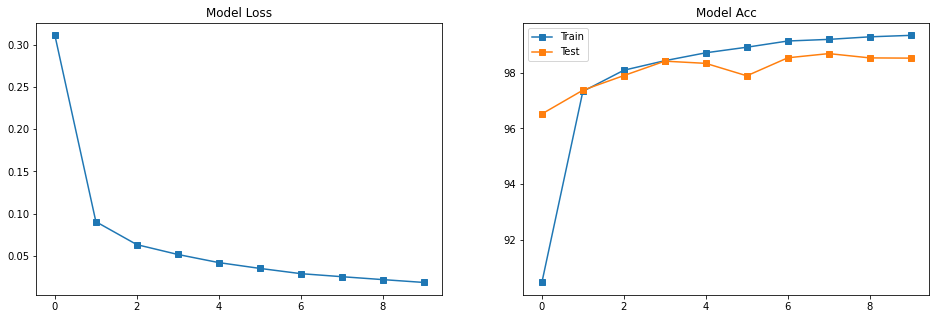

In [9]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_title('Model Loss')

ax[1].plot(trainAcc,'s-', label='Train')
ax[1].plot(testAcc,'s-', label='Test')
ax[1].set_title('Model Acc')
ax[1].legend()

plt.show()

In [10]:
print('Final Accuracy : ', testAcc[-1])

Final Accuracy :  tensor(98.5167)
